# Trial of various feature selection algorithms


In [1]:
import os
from sys import stdout
import time

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
import scipy.io
from sklearn import model_selection
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.feature_selection import RFE, RFECV
from deap import base
from deap import creator
from deap import tools

#from feature_selection import *




import warnings
warnings.filterwarnings('ignore')

In [3]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [4]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [5]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [6]:
"""x_df.shape
plt.plot(wl, x_df.T)
plt.show()

x_std= snv(x_df.values)
plt.plot(wl, x_std.T)
plt.show()"""

'x_df.shape\nplt.plot(wl, x_df.T)\nplt.show()\n\nx_std= snv(x_df.values)\nplt.plot(wl, x_std.T)\nplt.show()'

In [7]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [8]:
def genetic_algorithm(X, y):

    autoscaled_X_train= X
    autoscaled_y_train=y



    # GAPLS
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    min_boundary = np.zeros(X_train.shape[1])
    max_boundary = np.ones(X_train.shape[1]) * 1.0
    #print(min_boundary.shape)
    #print(max_boundary.shape)


    ###this one is for selecting at random the "individual"
    def create_ind_uniform(min_boundary, max_boundary):
        index = []
        for min, max in zip(min_boundary, max_boundary):
            index.append(random.uniform(min, max))
        return index


    toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)


    def evalOneMax(individual):
        individual_array = np.array(individual)
        #individual array is an array of lenght "wl" with values between 0 and 1. 
        #print("individual_array", individual_array.shape)

        selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
        #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
        #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)

        selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
        #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)


        if len(selected_X_variable_numbers):
            # cross-validation
            #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))

            #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))

            pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                              max_number_of_components + 1), 1)
            #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
            #                                  max_number_of_components + 1), 1)
            #print("pls components: ", pls_components)

            r2_cv_all = []

            for pls_component in pls_components:

                model_in_cv = PLSRegression(n_components=pls_component)

                #print("selected_autoscaled_X_train",selected_autoscaled_X_train)

                estimated_y_train_in_cv = np.ndarray.flatten(
                    model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))



                estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
                r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
            #print(len(r2_cv_all))
            #print("r2_cv_all: ",r2_cv_all)
            """
            try:
                value = np.max(r2_cv_all)
            except ValueError:  #raised if `y` is empty.
                value = -999
                pass
            """
            value = np.max(r2_cv_all)

        else:
            value = -999

        return value,


    toolbox.register('evaluate', evalOneMax)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)

    # random.seed(100)
    random.seed()
    pop = toolbox.population(n=number_of_population)

    print('Start of evolution')

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(pop))

    for generation in range(number_of_generation):
        print('-- Generation {0} --'.format(generation + 1))

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < probability_of_crossover:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < probability_of_mutation:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print('  Evaluated %i individuals' % len(invalid_ind))

        pop[:] = offspring
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5

        print('  Min %s' % min(fits))
        print('  Max %s' % max(fits))
        print('  Avg %s' % mean)
        print('  Std %s' % std)

    print('-- End of (successful) evolution --')

    best_individual = tools.selBest(pop, 1)[0]
    best_individual_array = np.array(best_individual)
    selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
    print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

In [9]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [10]:
"""# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_train, y_train)
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_train.T)
    plt.ylabel('First derivative absorbance spectra')
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()
"""

"# Define the PLS regression object\npls = PLSRegression(n_components=8)\n# Fit data\npls.fit(X_train, y_train)\n# Plot spectra\nplt.figure(figsize=(8,9))\nwith plt.style.context(('ggplot')):\n    ax1 = plt.subplot(211)\n    plt.plot(wl, X_train.T)\n    plt.ylabel('First derivative absorbance spectra')\n    ax2 = plt.subplot(212, sharex=ax1)\n    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!\n    plt.xlabel('Wavelength (nm)')\n    plt.ylabel('Absolute value of PLS coefficients')\n    plt.show()\n"

# Data loading

In [35]:
x_df = pd.read_csv('./avg_base_wl_sum_20-03.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(44, 4093)
(4093,)
44


,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.246900,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500
0,-0.000203,-0.000154,-0.000240,-0.000071,-0.000227,-0.000091,-0.000079,-0.000060,-0.000120,-0.000048,...,0.000307,0.000324,0.000678,0.000708,0.000924,0.000569,0.000334,0.000110,0.000127,0.000014
1,-0.000089,-0.000074,-0.000090,-0.000056,-0.000060,-0.000030,-0.000016,-0.000010,-0.000026,-0.000009,...,0.000398,0.000902,0.001324,0.001735,0.001818,0.001135,0.000576,0.000294,0.000177,0.000134
2,-0.000222,-0.000162,-0.000263,-0.000074,-0.000250,-0.000098,-0.000084,-0.000067,-0.000139,-0.000062,...,0.000137,-0.000112,0.000059,-0.000112,0.000094,0.000019,0.000045,-0.000059,0.000026,-0.000082
3,-0.000320,-0.000231,-0.000389,-0.000088,-0.000380,-0.000141,-0.000130,-0.000097,-0.000203,-0.000081,...,0.000201,-0.000164,0.000118,-0.000156,0.000156,0.000028,0.000066,-0.000098,0.000051,-0.000127
4,-0.000329,-0.000246,-0.000385,-0.000110,-0.000370,-0.000152,-0.000134,-0.000103,-0.000201,-0.000087,...,0.000232,-0.000026,0.000286,0.000100,0.000401,0.000180,0.000130,-0.000061,0.000059,-0.000114
5,-0.000186,-0.000142,-0.000217,-0.000071,-0.000204,-0.000086,-0.000073,-0.000058,-0.000110,-0.000047,...,0.000251,0.000279,0.000592,0.000632,0.000824,0.000491,0.000275,0.000085,0.000103,0.000008
6,-0.000217,-0.000158,-0.000260,-0.000068,-0.000255,-0.000100,-0.000090,-0.000068,-0.000136,-0.000057,...,0.000135,-0.000062,0.000153,0.000017,0.000240,0.000107,0.000112,0.000021,0.000142,0.000042
7,-0.000273,-0.000199,-0.000331,-0.000075,-0.000329,-0.000125,-0.000114,-0.000083,-0.000172,-0.000065,...,0.000171,-0.000135,0.000112,-0.000124,0.000137,0.000020,0.000046,-0.000094,0.000037,-0.000120
8,-0.000165,-0.000122,-0.000191,-0.000058,-0.000182,-0.000075,-0.000065,-0.000051,-0.000097,-0.000038,...,0.000227,0.000278,0.000582,0.000637,0.000824,0.000497,0.000279,0.000108,0.000134,0.000051
9,-0.000199,-0.000146,-0.000237,-0.000066,-0.000226,-0.000087,-0.000080,-0.000061,-0.000124,-0.000055,...,0.000120,-0.000097,0.000064,-0.000087,0.000103,0.000027,0.000039,-0.000052,0.000028,-0.000067


[[188.1951]
 [188.2601]
 [188.325 ]
 ...
 [440.6184]
 [440.6714]
 [440.7245]]


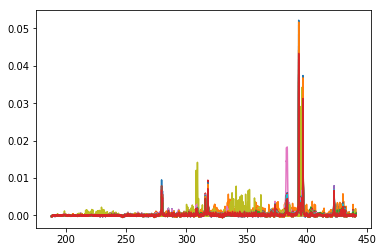

In [36]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("./data/002_Fe_200Hz_QS295us_Trig1430_exp1ms.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""

In [26]:
#df_y = pd.read_csv('./slag_concentration_noPure.csv', sep = ',', header=0)
df_y = pd.read_csv('./slag_concentration.csv', sep = ',')

#df_y = pd.read_csv('./123.txt', sep = '\t')

#df_y['Ca_tot'] = df_y.apply(lambda x: x['CaO'] + x['CaF2'], axis=1)
#df_y=df_y.drop(['CaO', 'CaF2'], axis=1)

print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(44, 19)


,ref_number,ref_name,S,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2,MoO3,NiO,Na2O,K2O,NbO
0,0,H06,0.030,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10,0.00,0.02,0.01,0.02,0.05
1,1,_Fe_pure,0.000,0.0,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,U08,0.200,53.0,0.00,8.94,25.50,11.80,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,O02,0.000,41.3,1.20,7.90,3.80,35.30,1.30,2.00,3.90,0.01,0.10,0.83,0.00,0.07,0.00,0.00,0.00
4,4,F100,0.040,14.1,0.00,3.90,25.10,40.90,3.90,0.11,0.13,0.04,0.00,0.81,0.00,0.00,5.40,5.40,0.00
5,5,H09,0.033,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12,0.00,0.02,0.04,0.03,0.05
6,6,U04,0.000,41.0,2.81,18.40,5.72,25.40,3.46,0.49,1.08,0.00,0.40,0.22,0.00,0.00,0.00,0.00,0.00
7,7,O05,0.000,39.2,1.10,8.40,3.70,34.30,1.70,1.30,9.30,0.01,0.11,0.92,0.00,0.38,0.00,0.00,0.00
8,8,U03,0.000,33.4,1.72,7.20,6.70,5.85,35.00,3.79,2.05,0.20,0.30,0.45,1.06,0.00,0.00,0.00,0.00
9,9,U12,0.300,44.5,0.00,24.40,22.10,7.54,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [37]:
frames = [df_y, x_df]

a = pd.concat(frames, axis=1)
#print(a)
b=a.sort_values(by=['ref_name'])
#print(b)
c= b[:-5]
c=c.sort_values(by=['ref_number'])
#print(c)
y_new = c.iloc[:, : df_y.shape[1]]
x_new = c.iloc[:, df_y.shape[1] :]

x_new.to_csv("avg_sum_noPure.csv")

In [34]:
x_new

,188.195100,188.260100,188.325000,188.390000,188.455000,188.520000,188.585000,188.650000,188.714900,188.779900,...,440.246900,440.300000,440.353000,440.406100,440.459200,440.512300,440.565300,440.618400,440.671400,440.724500
0,-0.008984,-0.006894,-0.010341,-0.003543,-0.009475,-0.004007,-0.003265,-0.002508,-0.004839,-0.001820,...,0.026248,0.041126,0.068169,0.080634,0.090809,0.059629,0.034088,0.016846,0.013508,0.007991
2,-0.006239,-0.004601,-0.007360,-0.002132,-0.007009,-0.002812,-0.002390,-0.001903,-0.003879,-0.001759,...,0.003705,-0.003096,0.001747,-0.002898,0.002857,0.000616,0.001225,-0.001700,0.000630,-0.002308
3,-0.007512,-0.005453,-0.009150,-0.002092,-0.009008,-0.003369,-0.003136,-0.002337,-0.004787,-0.001898,...,0.004669,-0.003574,0.003243,-0.003004,0.004316,0.000958,0.001620,-0.002305,0.001261,-0.002956
4,-0.008213,-0.006123,-0.009540,-0.002913,-0.009073,-0.003823,-0.003331,-0.002604,-0.004978,-0.002222,...,0.006248,0.001480,0.010051,0.006794,0.014241,0.007033,0.004328,-0.000895,0.001675,-0.002461
5,-0.007876,-0.006075,-0.009075,-0.003215,-0.008412,-0.003642,-0.002994,-0.002366,-0.004524,-0.001940,...,0.012959,0.018509,0.034597,0.039886,0.048219,0.029326,0.015829,0.006026,0.005735,0.001802
6,-0.006739,-0.004935,-0.008057,-0.002159,-0.007878,-0.003152,-0.002808,-0.002149,-0.004218,-0.001791,...,0.004257,-0.000974,0.006242,0.002804,0.009902,0.004913,0.004521,0.001978,0.006035,0.003283
7,-0.007698,-0.005637,-0.009298,-0.002134,-0.009271,-0.003528,-0.003264,-0.002349,-0.004872,-0.001819,...,0.004846,-0.003374,0.003730,-0.002773,0.004590,0.000855,0.001295,-0.002655,0.001054,-0.003348
8,-0.007754,-0.005867,-0.008846,-0.003042,-0.008207,-0.003500,-0.002924,-0.002392,-0.004376,-0.001784,...,0.014448,0.024955,0.044690,0.053548,0.063075,0.039018,0.021003,0.010343,0.010430,0.006986
9,-0.006088,-0.004500,-0.007232,-0.002112,-0.006850,-0.002717,-0.002441,-0.001893,-0.003784,-0.001711,...,0.003540,-0.002751,0.002276,-0.001989,0.003815,0.001171,0.001248,-0.001560,0.000747,-0.001952
10,-0.008923,-0.006763,-0.010522,-0.003106,-0.010052,-0.004182,-0.003737,-0.002921,-0.005467,-0.002176,...,0.012700,0.015622,0.032500,0.035515,0.045568,0.027309,0.014804,0.004002,0.004521,-0.000608


In [16]:
y_val = concentration[:,1] #1-Mg, 2-Al, 3-Si, 4-Fe, 5-Mn, Ca-10 (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[0.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 12.0 13.0 14.0 15.0 17.0 19.0
 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0
 34.0 35.0 36.0 37.0 39.0 40.0 41.0 42.0 43.0]
(39,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state = 16)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

ValueError: Found input variables with inconsistent numbers of samples: [44, 39]

In [18]:
#optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

In [19]:
# Define PLS object
pls =  PLSRegression(n_components=20)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

NameError: name 'X_train' is not defined

In [20]:
T, P, U, Q, W, C, beta = pls.x_scores_, pls.x_loadings_, pls.y_scores_, pls.y_loadings_, pls.x_weights_, pls.y_weights_, pls.coef_

AttributeError: 'PLSRegression' object has no attribute 'x_scores_'

In [179]:
start_time = time.time()
selector = RFE(pls, 1000, step=1)
#selector = RFECV(pls , cv=5)
selector = selector.fit(x_df.values, y_df.values)
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.63707947731018 seconds ---


In [180]:
b=selector.support_
#selector.ranking_


In [181]:
x_selecta = x_df.values[:,b]
print(x_df.shape, x_selecta.shape)

(34, 3648) (34, 1000)


100% completed
Suggested number of components:  4



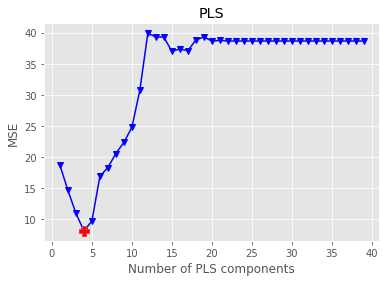

R2 calib: 0.818
R2 CV: 0.688
MSE calib: 4.719
MSE CV: 8.097


In [176]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=13)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state=13)

optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

R2_pred:  0.2025427247250564
RMSE:  5.107537878197148



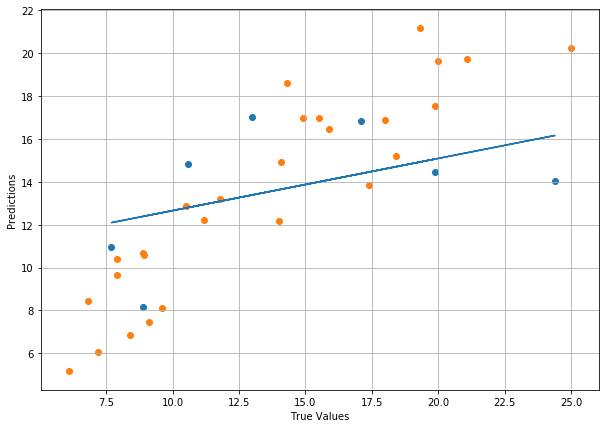

In [178]:
# Define PLS object
pls =  PLSRegression(n_components=5)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [19]:
T.shape

(27, 20)

In [20]:
P.shape

(3648, 20)

In [21]:
W.shape

(3648, 20)

In [22]:
beta.shape

(3648, 1)

In [25]:
Z = np.identity(len(beta))
#Z.shape

(3648, 3648)

In [94]:
#X_std= snv(X_train.values)
X_std= StandardScaler().fit_transform(X_train.values.T).T
#X_std= StandardScaler().fit_transform(X_train.values)
print(X_std.shape)
#y_std= snv(y_train.values.T) #already transposed
y_std= StandardScaler().fit_transform(y_train.values)
print(y_std.shape)

(27, 3648)
(27, 1)


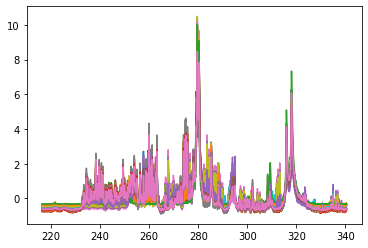

In [87]:
plt.plot(wl,X_std.T)
plt.show()

In [88]:
X = np.matmul(X_std,Z)
X

array([[-0.46998493, -0.47758437, -0.47658804, ..., -0.32317773,
        -0.34388175, -0.38880414],
       [-0.69939139, -0.70608443, -0.70672618, ..., -0.64832608,
        -0.64359934, -0.6393805 ],
       [-0.75930174, -0.76707287, -0.76801376, ..., -0.74105066,
        -0.73019679, -0.71747785],
       ...,
       [-0.61021825, -0.61530059, -0.61535192, ..., -0.5016077 ,
        -0.50728504, -0.52481633],
       [-0.64946393, -0.65565664, -0.65571276, ..., -0.63744853,
        -0.63099054, -0.62337007],
       [-0.63189945, -0.63740886, -0.63746386, ..., -0.62589782,
        -0.61827404, -0.60901037]])

In [97]:
w=np.matmul(y_std.T,X)
tmp=np.matmul(y_std.T, y_std)
w= w/tmp
w=w.T
print(w.shape)
w= w/np.linalg.norm(w)

(3648, 1)


In [98]:
t=np.matmul(X,w)
print(t.shape)
print(y_std.shape)

(27, 1)
(27, 1)


In [101]:
c=np.matmul(t.T,y_std)
print(c.shape)
tmp1=np.matmul(t.T,t)
print(tmp1.shape)
c=np.divide(c,tmp1)

(1, 1)
(1, 1)


In [102]:
p_T=np.matmul(t.T,X_std)
print(p_T.shape)
p_T=np.divide(p_T,tmp1)

(1, 3648)


In [107]:
X = X - t*p_T
y= y_std - c*t

In [ ]:
y_std= snv(y_train.values.T) #already transposed
y_std.shape

In [68]:
y_std2= StandardScaler().fit_transform(y_train.values)
y_std2.shape

(27, 1)

In [66]:
y_std

array([[-1.0539078584653752, 0.6352158961982641, -0.5738411071399199,
        0.2973911452655364, -0.5916213571890108, 1.8798333996346301,
        -1.3739523593490124, -0.8761053579744659, -1.0539078584653752,
        -0.3604781065508284, 1.2930851480146295, -0.4671596068453743,
        1.097502397474629, 1.0797221474255376, -1.2494906090053757,
        -0.8405448578762841, -0.7516436076308294, -1.1783696088090119,
        -0.9650066082199206, 1.9865148999291762, 0.9730406471309925,
        1.0797221474255376, -0.8689932579548296, 0.5818751460509918,
        0.19070964497099083, 0.7418973964928101, 0.36851214546190025]],
      dtype=object)

# MSVC, MC-UVE, RT, VC

In [321]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_df, y_df, test_size=0.2)
print(Ytest)

wl=wl.astype('float32')
Xtrain=Xtrain.values.astype('float32')
Ytrain=Ytrain.values.astype('float32')
Xtest=Xtest.values.astype('float32')
Ytest=Ytest.values.astype('float32')

        0
11  36.41
19   41.5
1   44.72
13   42.5
9   42.64
29     53
7   45.29


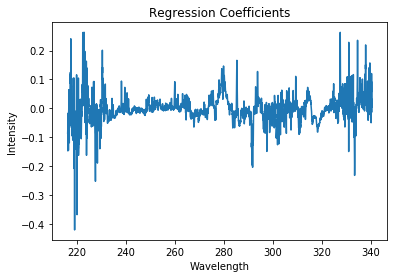

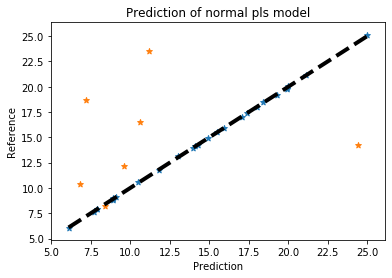

before feature selection
R2_pred:  -1.003893565088497
RMSE:  7.9423505132616885


KeyboardInterrupt: 

In [245]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# Stability of MC-UVE
mcModel = MCUVE(Xtrain, Ytrain, ncomp)
mcModel.calcCriteria()
plt.plot(mcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Stability of MCUVE")
plt.savefig("./Image3_Stability.png")
plt.show()

# Feature ranking efficienty by stability of MC-UVE
mcModel.evalCriteria(cv=5)
plt.plot(mcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by MC-UVE
XtrainNew, XtestNew = mcModel.cutFeature(Xtrain, Xtest)
print(XtrainNew.shape)

#plsModelNew = PLSRegression(n_components=ncomp)
plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))

plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MC-UVE")
plt.savefig("./Image5_Prediction_MC_UVE.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [73]:
print(len(mcModel.selFeature))
mc_index= mcModel.selFeature

421


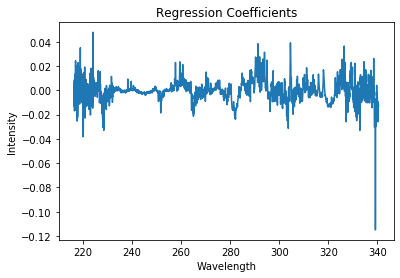

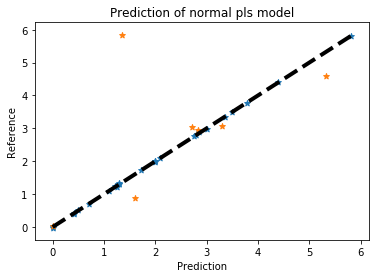

before feature selection
R2_pred:  -0.23890296144442225
RMSE:  1.7395453632731597


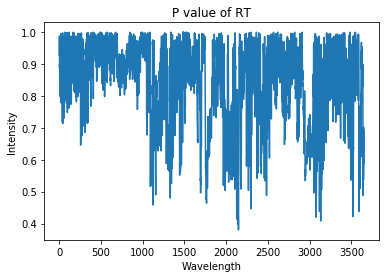

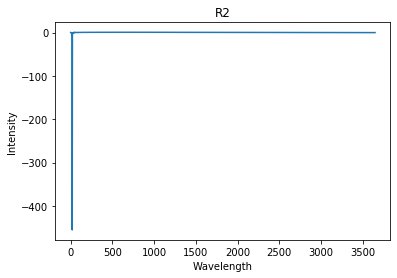

(27, 653)


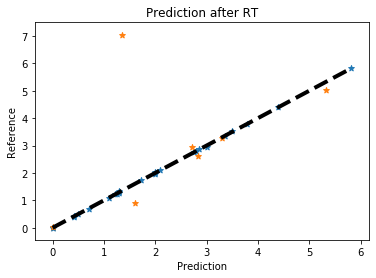

after feature selection
R2_pred:  -0.9282185099154832
RMSE:  2.170177401910291


In [52]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()

r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)


# P value of RT
rtModel = RT(Xtrain, Ytrain, ncomp)
rtModel.calcCriteria()
plt.plot(rtModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("P value of RT")
plt.savefig("./Image3_P_vale.png")
plt.show()

# Feature ranking efficienty by stability of RT
rtModel.evalCriteria(cv=5)
plt.plot(rtModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by RT
XtrainNew, XtestNew = rtModel.cutFeature(Xtrain, Xtest)
print(XtrainNew.shape)

plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
#plsModelNew = PLSRegression(n_components=ncomp)

plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after RT")
plt.savefig("./Image5_Prediction_RT.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [ ]:
print(len(rtModel.selFeature))
rt_index= rtModel.selFeature

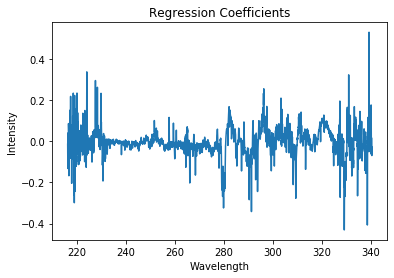

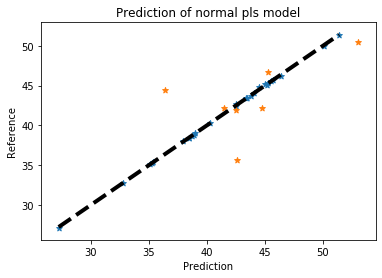

before feature selection
R2_pred:  0.14919901249460588
RMSE:  4.278397529302029


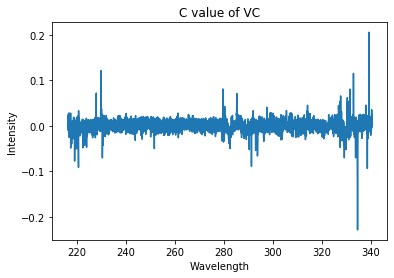

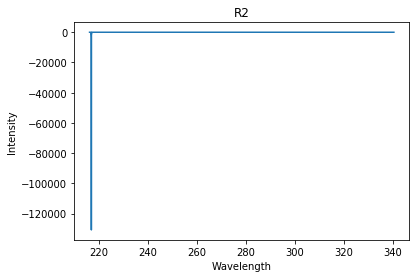

(27, 189)


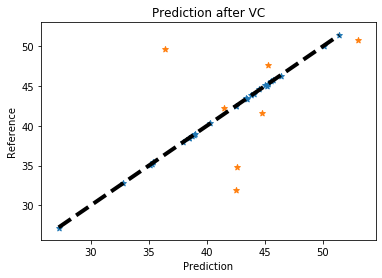

after feature selection
R2_pred:  -1.4451891858662749
RMSE:  7.253095158782


In [322]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()


r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of VC
vcModel = VC(Xtrain, Ytrain, ncomp, nrep=7000)
vcModel.calcCriteria()
plt.plot(wl, vcModel.criteria)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("C value of VC")
plt.savefig("./Image3_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
vcModel.evalCriteria(cv=5)
plt.plot(wl, vcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = vcModel.cutFeature(Xtrain, Xtest)
print(XtrainNew.shape)

plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
#plsModelNew = PLSRegression(n_components=ncomp)

plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after VC")
plt.savefig("./Image5_Prediction_VC.png")
plt.show()

r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [323]:
print(len(vcModel.selFeature))
vc_index= vcModel.selFeature
print(vc_index)

189
[3442 3443 3440 3441 3444 3439 3580  114 2064   73 3438  113  368 3415
 3259 2137 2138 3258  369 2139 2115 2038 3282 2037   87 2063 2140 3284
  936 1806 3283 3414   96   32  159 3445 3202  200 3260 3266 3254  178
  112  375  199 3203 3446  370  196 2114   42 1795 2116 1796 3280 2136
 2036  367 1728 2215 2141 3230 1709 1793 1738 1731 1792 3278  725  198
 3277 3447 2428 3267 3319 1715 2741 2002 3281 2441 3261 3229 2117 2118
  801 2119 2429 3252   59 3265  376 2982 1729 1789 3412 1974 3502 3592
 3286 2213 1805   85 1794   76   30 3293  264 1206  293 2034 1944 3399
 3257 1813   16 2001 2620 3341  104 3302 2963 3437 1818 1790 1810 2653
  181 2582  895 3170  202 2975 1803   25 3253 2425   78 1975 2629  399
 3113 2617 1634  167 2615 2404 3345 1718 2564 2753 2440  380  396  129
 1513 2959 1716 1986 3174  938 3262 2992 1816 1090  789   97 1044 3413
 1807 2013  374 2680 1104 1802 3628  943 1945 2051 2386 1042 3236 2065
 3501 1175  208 2618 2685 3448 2619]


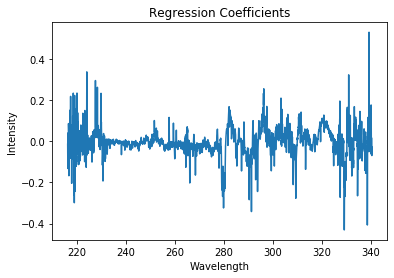

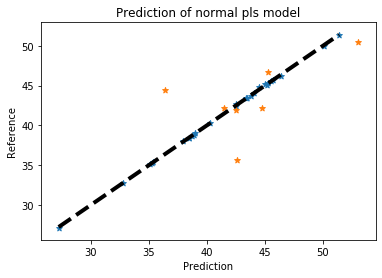

before feature selection
R2_pred:  0.14919901249460588
RMSE:  4.278397529302029


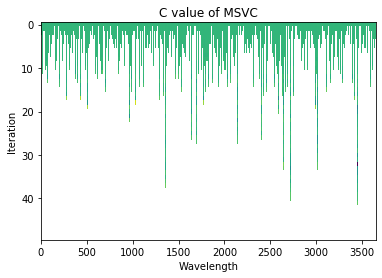

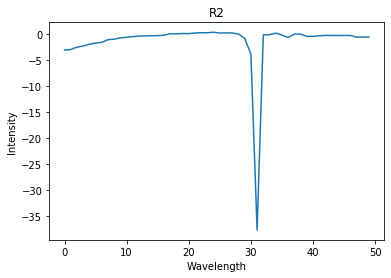

(27, 66)


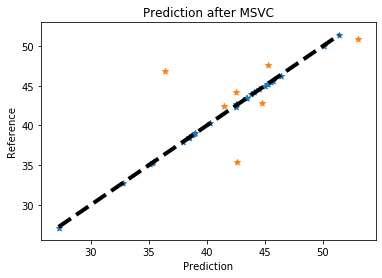

after feature selection
R2_pred:  -0.1885354556301635
RMSE:  5.056770142559708


In [324]:
ncomp=20

plsModel = PLSRegression(n_components=ncomp)
plsModel.fit(Xtrain, Ytrain)
T, P, U, Q, W, C, beta = plsModel.x_scores_, plsModel.x_loadings_, plsModel.y_scores_, plsModel.y_loadings_, plsModel.x_weights_, plsModel.y_weights_, plsModel.coef_
plt.plot(wl, beta[0:])
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Regression Coefficients")
plt.savefig("./Image1_RegressionCoefficient_PLS.png")
plt.show()

# Prediction result of pls model
Ytrain_hat = plsModel.predict(Xtrain)
Ytest_hat = plsModel.predict(Xtest)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, Ytrain_hat, marker='*')
plt.scatter(Ytest, Ytest_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction of normal pls model")
plt.savefig("./Image2_PredictionPLS.png")
plt.show()



r2 = r2_score(Ytest, Ytest_hat)
rmse = sqrt(mean_squared_error(Ytest, Ytest_hat))
print("before feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)



# C value of MSVC
msvcModel = MSVC(Xtrain, Ytrain, ncomp, nrep=500)
msvcModel.calcCriteria()
plt.imshow(msvcModel.criteria, aspect='auto')
plt.xlabel("Wavelength")
plt.ylabel("Iteration")
plt.title("C value of MSVC")
plt.savefig("./Image3_MS_C_vale.png")
plt.show()

# Feature ranking efficienty by stability of VC
msvcModel.evalCriteria(cv=5)
plt.plot(msvcModel.featureR2)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("R2")
plt.savefig("./Image4_R2.png")
plt.show()

# Prediction results after feature selection by VC
XtrainNew, XtestNew = msvcModel.cutFeature(Xtrain, Xtest)
print(XtrainNew.shape)

plsModelNew = PLSRegression(n_components=min([ncomp, rank(XtrainNew)]))
plsModelNew.fit(XtrainNew, Ytrain)
YtrainNew_hat = plsModelNew.predict(XtrainNew)
YtestNew_hat = plsModelNew.predict(XtestNew)
plt.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
plt.scatter(Ytrain, YtrainNew_hat, marker='*')
plt.scatter(Ytest, YtestNew_hat, marker='*')
plt.xlabel("Prediction")
plt.ylabel("Reference")
plt.title("Prediction after MSVC")
plt.savefig("./Image5_Prediction_MSVC.png")
plt.show()


r2 = r2_score(Ytest, YtestNew_hat)
rmse = sqrt(mean_squared_error(Ytest, YtestNew_hat))
print("after feature selection")
print("R2_pred: ", r2)
print("RMSE: ", rmse)

In [327]:
print(len(msvcModel.selFeature))
msvc_index= msvcModel.selFeature
#msvc_index= vcModel.featureR2
print(msvc_index)

3648
[False False False ... False False False]


In [328]:
#print(vc_index.shape, vc_index)
#print(msvc_index.shape, msvc_index)
x_msvc= x_df.iloc[:,msvc_index]
x_vc= x_df.iloc[:,vc_index]


In [351]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=16)
X_train, X_test, y_train, y_test = train_test_split(x_vc, y_df, test_size=0.2, random_state=16)
X_train, X_test, y_train, y_test = train_test_split(x_msvc, y_df, test_size=0.2, random_state=16)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 66) (27, 1)
(7, 66) (7, 1)
        0
31   50.1
7   45.29
22  27.24
25  43.81
6   46.35
28   51.4
19   41.5


R2_pred:  0.7843599976385904
RMSE:  3.4464482925077604



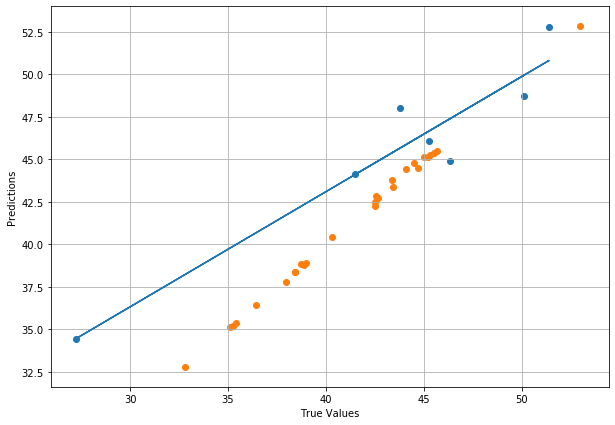

In [352]:
# Define PLS object
pls =  PLSRegression(n_components=20)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [164]:

X_train=XtrainNew
y_train=Ytrain
X_test=XtestNew
y_test=Ytest

R2_pred:  0.8019418403440541
RMSE:  0.46706460003285216



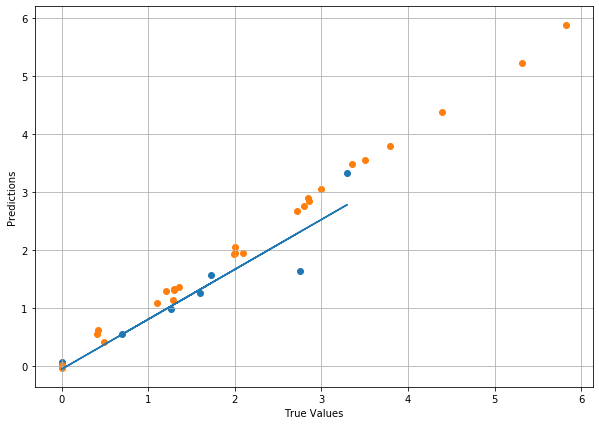

In [62]:
# Define PLS object
pls =  PLSRegression(n_components=10)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# VIP filter selection

In [199]:
a= _calculate_vips(pls)
print(a)
b=[]
for i in range(len(a)):
    #if a[i]> 1.21:
    if a[i]> 0.83:
        b.append(i)

x_selecta = pd.DataFrame(x_df.values[:,b])
print(x_selecta.shape)

[1.4890095  1.37164199 1.34654083 ... 1.37406199 1.39633466 1.40216631]
(34, 2000)


100% completed
Suggested number of components:  3



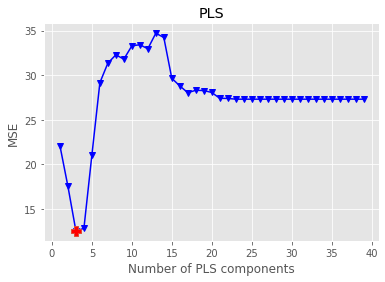

R2 calib: 0.766
R2 CV: 0.595
MSE calib: 7.233
MSE CV: 12.511


In [203]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state=10)

optimise_pls_cv(X_train, y_train, 40, plot_components=True) 

R2_pred:  0.1331982227125812
RMSE:  3.5028590327485567



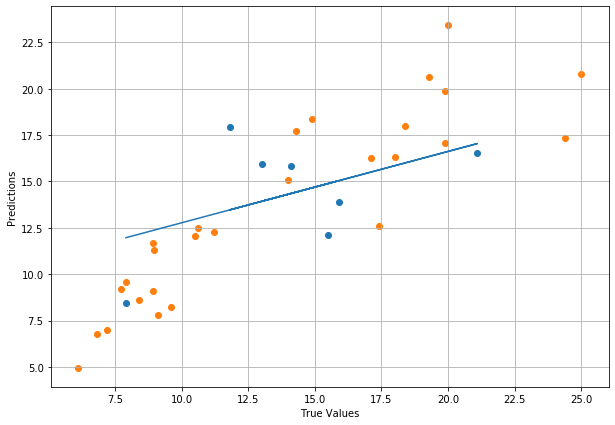

In [204]:
# Define PLS object
pls =  PLSRegression(n_components=4)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# wavelength selection with *i*-PLS 
NIRpy function

100% completed
Optimised number of PLS components:  2
Wavelengths to be discarded  1516
Optimised MSEP  8.466520218820857

--- 744.0878531932831 seconds ---
sorted wavelengths:  [[276.87 227.95 276.77 285.5  227.42 259.82 227.46 285.43 219.93 226.24]]


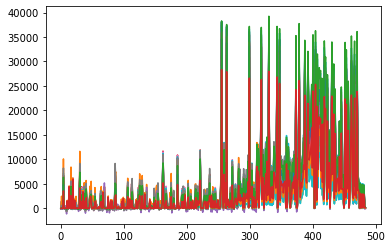

In [206]:
start_time = time.time()
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
print("--- %s seconds ---" % (time.time() - start_time))

print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [276]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 484) (27, 1)
(7, 484) (7, 1)
       0
15   8.9
1     18
3   15.5
22  14.1
14   9.6
11  17.4
4   17.1


In [277]:
#optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.3759446660495579
RMSE:  2.7338417021767674



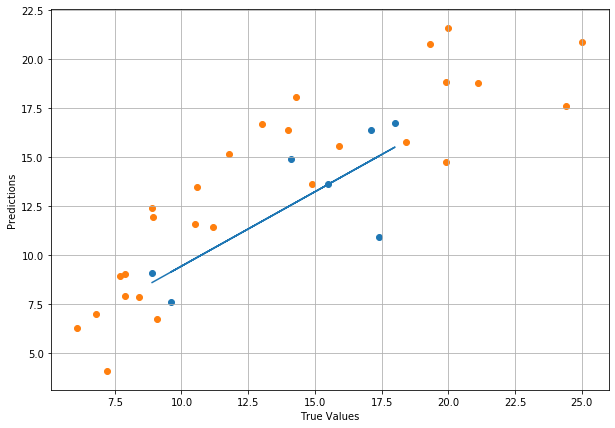

In [278]:
# Define PLS object
pls = PLSRegression(n_components=2)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Genetic Algorithm with PLS

In [15]:
# GA settings
number_of_population = 200
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.01
threshold_of_variable_selection = 0.5

# input
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#print(autoscaled_X_train.shape)
#print(autoscaled_y_train.shape)

#genetic_algorithm(autoscaled_X_train,autoscaled_y_train)

(34, 3648)
(34,)
33


In [25]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [103]:
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 348) (27, 1)
(7, 348) (7, 1)
       0
10  11.2
30  19.9
1     18
2   21.1
31    14
33  24.4
16   8.4


37% completed
Suggested number of components:  2



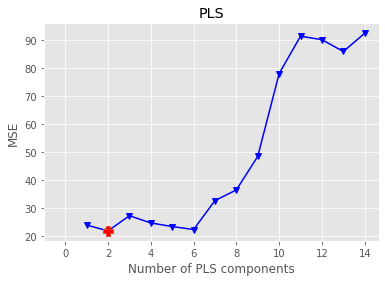

R2 calib: 0.349
R2 CV: 0.101
MSE calib: 15.815
MSE CV: 21.849


In [104]:
optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.09441884308116721
RMSE:  1.4843109346366985



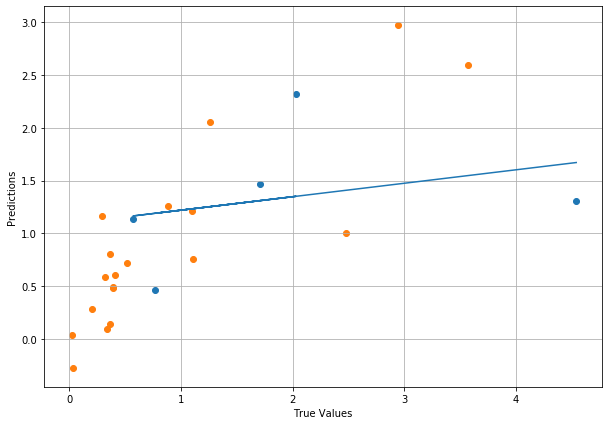

In [30]:
# Define PLS object
pls =  PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [25]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  177
Optimised MSEP  0.4391647684828197

--- 32.15109443664551 seconds ---


sorted wavelengths:  [271.5639 272.3414 262.0899 257.669  264.8179 271.9527 261.3101 264.1685
 265.0776 253.1133]


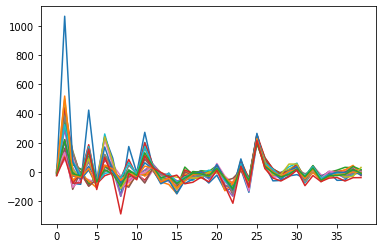

In [26]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [44]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 39) (19, 1)
(5, 39) (5, 1)
        0
19  0.339
5   0.360
23  2.030
21  2.480
12  0.320


100% completed
Suggested number of components:  14



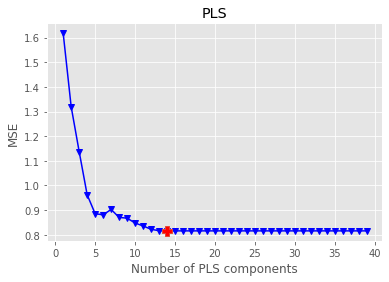

R2 calib: 1.000
R2 CV: 0.452
MSE calib: 0.000
MSE CV: 0.816


In [45]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.7360721453243093
RMSE:  0.4876059430361719



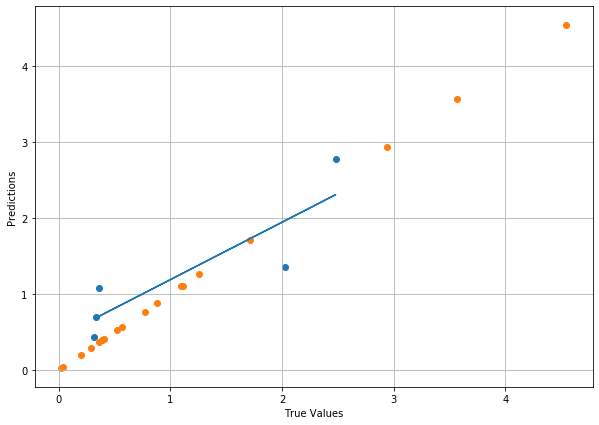

In [47]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

Best ones so far:

#1
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.3
threshold_of_variable_selection = 0.6


#2
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.25
threshold_of_variable_selection = 0.5


# Elastic Net

In [73]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:33.17, RMSE:5.76
Alpha:0.0010, R2:1.00, MSE:33.05, RMSE:5.75
Alpha:0.0100, R2:1.00, MSE:32.83, RMSE:5.73
Alpha:0.1000, R2:1.00, MSE:35.80, RMSE:5.98
Alpha:0.3000, R2:1.00, MSE:39.47, RMSE:6.28
Alpha:0.5000, R2:1.00, MSE:41.57, RMSE:6.45
Alpha:0.7000, R2:1.00, MSE:41.85, RMSE:6.47
Alpha:1.0000, R2:1.00, MSE:41.13, RMSE:6.41


In [74]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9999768383309343
RMSE:  5.759070542511677
R^2:  -0.44802625066170787


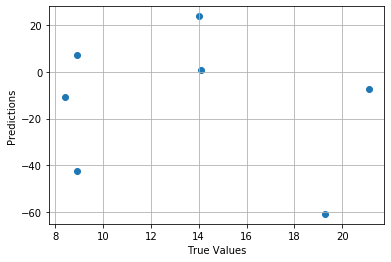

In [75]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [76]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


RMSE:  3.2004078262978712
R^2:  0.5528200879619326 

[real, predictions]
[[14.1 15.032080000000029]
 [14.0 16.45600000000004]
 [8.9 9.520960000000006]
 [21.1 16.531200000000013]
 [8.4 8.7544]
 [8.9 15.052880000000046]
 [19.3 16.943200000000015]]


Text(0, 0.5, 'Predictions')

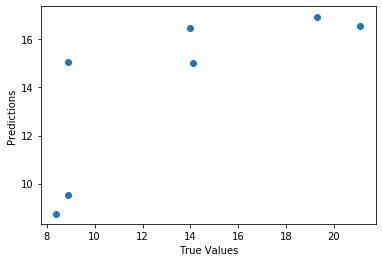

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

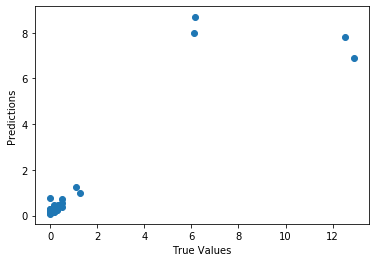

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



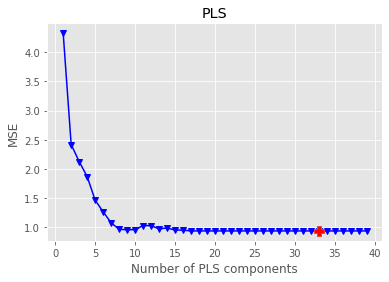

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
